#### Human activity recognition feature representations with convolutional autoencoder

The model architecture and feature engineering methods from the following paper are implemented

[On the Role of Features in HAR](https://dl.acm.org/doi/10.1145/3341163.3347727)

Classification: probabilistic classification with MLP

In [1]:
import torch
import numpy as np
import os
import pandas as pd
import json
import sys

from skopt import gp_minimize
from skopt.space import Integer, Real
import matplotlib.pyplot as plt

from skopt.plots import plot_convergence
from skopt.plots import plot_gaussian_process
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [5]:
sys.executable, torch.__version__

('c:\\Users\\arthu\\AppData\\Local\\Programs\\Python\\Python311\\python.exe',
 '2.5.1+cu118')

In [8]:
import torch.nn as nn
maxPoolLayer = nn.MaxPool2d(kernel_size=2, stride=2)
mA = torch.randn(1, 16, 129, 5)
mA.size()
mB = maxPoolLayer(mA)
mB.size()

torch.Size([1, 16, 64, 2])

In [19]:

module_dir = "../modules"
if module_dir not in sys.path:
    sys.path.append(module_dir)
    
from conv_ae_training_loop import train_and_save_conv_ae
import utils

# if there is trouble installing modules: compare python paths used in notebooks vs cmd
# print(sys.executable)
# !python -c "import sys; print(sys.executable)"

# install modules to the currently used python path in cmd
#%pip install scikit-optimize
# OR
#"C:\path\to\your\jupyter\python.exe" -m pip install scikit-optimize

# check what env jupyter is using, install the correct one
# jupyter kernelspec list
# python -m ipykernel install --user --name myenv --display-name "Python (myenv)"

# saving project requirements:
# pip freeze > requirements.txt
# pip install -r requirements.txt



In [ ]:
!jupyter kernelspec uninstall 

#### Probing

Testing out optimization with toy function

see [Documentation](https://scikit-optimize.readthedocs.io/en/latest/auto_examples/bayesian-optimization.html)

Best hyperparameters: [1.80184697370616, 1.6925925332435667]
Best objective function value: -1.9518120878421106


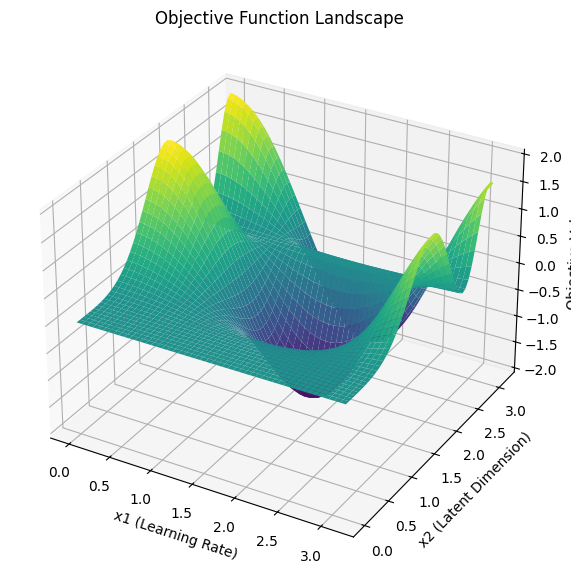

In [ ]:
# define the objective function
def objective_skopt(x):
    x1, x2 = x  # Extract values
    return np.cos(1.8 * x1) * (1 - np.cos(x2 ** 2))


# search space (will be hyperparams)
space = [
    Real(0, 3.14, name='x1'),  # Range for x1 (learning rate)
    Real(0, 3.14, name='x2')   # Range for x2 (latent dim)
]

res = gp_minimize(
    objective_skopt, # the objective function which is observed n_calls times
    space, # the parameter search space
    acq_func="EI", # idk what this means tbh
    n_calls=10, # how often function is observed
    n_random_starts=5 # number of observations before approximating the function
)

# Best found hyperparameters
print("Best hyperparameters:", res.x)
print("Best objective function value:", res.fun)

# visualization of objective function

def f(x1, x2):
    return np.cos(1.8 * x1) * (1 - np.cos(x2 ** 2))

x1_range = np.linspace(0, 3.14, 50)
x2_range = np.linspace(0, 3.14, 50)

X1, X2 = np.meshgrid(x1_range, x2_range)
Z = f(X1, X2)

fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X1, X2, Z, cmap="viridis", edgecolor='none')

ax.set_xlabel("x1 (Learning Rate)")
ax.set_ylabel("x2 (Latent Dimension)")
ax.set_zlabel("Objective Value")
ax.set_title("Objective Function Landscape")

plt.show()

In [1]:
# explore the res object

# can be saved as json and used for further optimization
# use plot_convergence(res) function for plotting
res

NameError: name 'res' is not defined

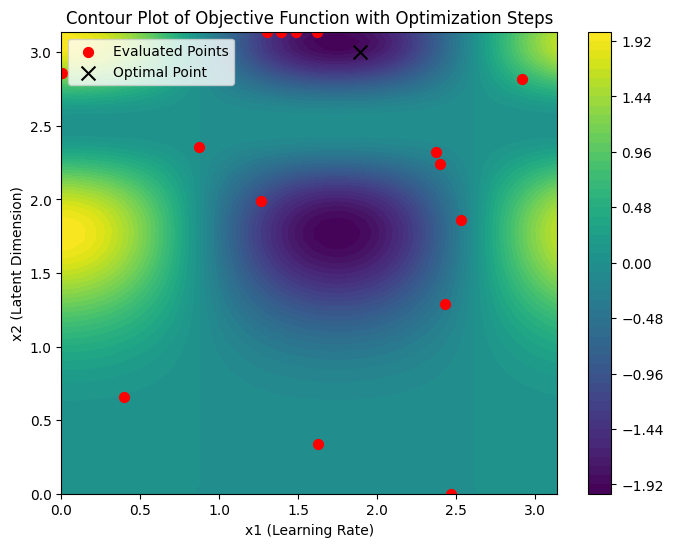

In [ ]:
plt.figure(figsize=(8,6))
contour = plt.contourf(X1, X2, Z, levels=50, cmap="viridis")
plt.colorbar(contour)

plt.scatter(x_iters[:, 0], x_iters[:, 1], color="red", marker="o", s=50, label="Evaluated Points")

plt.scatter(res.x[0], res.x[1], color="black", marker="x", s=100, label="Optimal Point")

# Labels and title
plt.xlabel("x1 (Learning Rate)")
plt.ylabel("x2 (Latent Dimension)")
plt.title("Contour Plot of Objective Function with Optimization Steps")
plt.legend()

plt.show()


#### Bayesian Parameter Optimization

Finds objective Loss function of model hyperparameters 

- randomly samples parameter space via initial_point_generator for n_initialial_points
- observes function values and approximates function with gaussian prior
- updates prior based on observed values

see [Documentation](https://scikit-optimize.github.io/stable/modules/generated/skopt.gp_minimize.html#skopt.gp_minimize)

In [ ]:

# search space of hyperparameters
param_space = [
    Integer(16,  128, name='latent_dim'), # latent dimension
    #Integer(1, 4, name='conv_blocks'), # number of convolutional blocks
    Integer(4, 32, name='init_channel') # initial channel size 
]

save_filepath = "..\\saved_models\\convolutional_autoencoder\\bayes_opt1\\"
training_epochs = 50

def objective_loss(x):
    ldim, initc = x
    ldim, initc = int(ldim), int(initc)

    print(f'Evaluation point: {ldim, initc}')

    config = {'latent_dim':ldim, 'conv_blocks':[1, initc], 'kernel':(3, 2), 'id':'BayesOpt1'}
    try:
        val_loss = train_and_save_conv_ae(config=config, num_epochs=training_epochs, save_filepath=save_filepath)
    except Exception as e:
        print(f'Trianing failed {e}')

    print(f'Achieved final validation loss of {val_loss}')
    return val_loss

# use x0, y0 parameters for initially observed points
result = gp_minimize(
    objective_loss, # the objective function which is observed n_calls times
    param_space, # the parameter search space
    n_calls=30, # how often function is observed
    n_initial_points=5, # number of observations before approximating the function
    random_state=7, 
    verbose=True,
    noise=1e-10
)

# Best found hyperparameters
print("Best hyperparameters:", result.x)
print("Best objective function value:", result.fun)
print(f'Optimization failed {e}')

Iteration No: 1 started. Evaluating function at random point.
Evaluation point: (41, 13)
Using 4 workers (CPU cores: 8, Available RAM: 1.82GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.7227350473403931
No saved weights found for conv_ae_ndim41_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\
No existing log data found for conv_ae_ndim41_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\convolutional_autoencoder\\bayes_opt\\', 'conv_ae_ndim41_convblocks2_kernel(3, 2)_idBayesSearch')


Model trained for 49 epochs. Saved data for conv_ae_ndim41_convblocks2_kernel(3, 2)_idBayesSearch
Achieved final validation loss of 0.3916305210441351
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 60.3892
Function value obtained: 0.3916
Current minimum: 0.3916
Iteration No: 2 started. Evaluating function at random point.
Evaluation point: (126, 17)
Using 4 workers (CPU cores: 8, Available RAM: 2.91GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.7708255052566528
No saved weights found for conv_ae_ndim126_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\
No existing log data found for conv_ae_ndim126_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\convolutional_autoencoder\\bayes_opt\\', 'conv_ae_ndim126_convblocks2_kernel(3, 2)

Model trained for 49 epochs. Saved data for conv_ae_ndim126_convblocks2_kernel(3, 2)_idBayesSearch
Achieved final validation loss of 0.3753380912045638
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 61.0527
Function value obtained: 0.3753
Current minimum: 0.3753
Iteration No: 3 started. Evaluating function at random point.
Evaluation point: (50, 11)
Using 4 workers (CPU cores: 8, Available RAM: 3.08GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.6710503697395325
No saved weights found for conv_ae_ndim50_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\
No existing log data found for conv_ae_ndim50_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\convolutional_autoencoder\\bayes_opt\\', 'conv_ae_ndim50_convblocks2_kernel(3, 2)_id

Model trained for 49 epochs. Saved data for conv_ae_ndim50_convblocks2_kernel(3, 2)_idBayesSearch
Achieved final validation loss of 0.38575013416508835
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 57.8970
Function value obtained: 0.3858
Current minimum: 0.3753
Iteration No: 4 started. Evaluating function at random point.
Evaluation point: (26, 16)
Using 4 workers (CPU cores: 8, Available RAM: 3.34GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.8525956273078918
No saved weights found for conv_ae_ndim26_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\
No existing log data found for conv_ae_ndim26_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\convolutional_autoencoder\\bayes_opt\\', 'conv_ae_ndim26_convblocks2_kernel(3, 2)_id

Model trained for 49 epochs. Saved data for conv_ae_ndim26_convblocks2_kernel(3, 2)_idBayesSearch
Achieved final validation loss of 0.40945586065451306
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 58.5800
Function value obtained: 0.4095
Current minimum: 0.3753
Iteration No: 5 started. Evaluating function at random point.
Evaluation point: (18, 19)
Using 4 workers (CPU cores: 8, Available RAM: 3.27GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.696031928062439
No saved weights found for conv_ae_ndim18_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\
No existing log data found for conv_ae_ndim18_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\convolutional_autoencoder\\bayes_opt\\', 'conv_ae_ndim18_convblocks2_kernel(3, 2)_idB

Model trained for 49 epochs. Saved data for conv_ae_ndim18_convblocks2_kernel(3, 2)_idBayesSearch
Achieved final validation loss of 0.43533499352633953
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 88.8310
Function value obtained: 0.4353
Current minimum: 0.3753
Iteration No: 6 started. Searching for the next optimal point.
Evaluation point: (128, 4)
Using 4 workers (CPU cores: 8, Available RAM: 2.70GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.7346827983856201
No saved weights found for conv_ae_ndim128_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\
No existing log data found for conv_ae_ndim128_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\convolutional_autoencoder\\bayes_opt\\', 'conv_ae_ndim128_convblocks2_kernel(3, 2

Model trained for 49 epochs. Saved data for conv_ae_ndim128_convblocks2_kernel(3, 2)_idBayesSearch
Achieved final validation loss of 0.3768567393223445
Iteration No: 6 ended. Search finished for the next optimal point.
Time taken: 55.9556
Function value obtained: 0.3769
Current minimum: 0.3753
Iteration No: 7 started. Searching for the next optimal point.
Evaluation point: (112, 4)
Using 4 workers (CPU cores: 8, Available RAM: 3.49GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.6856353282928467
No saved weights found for conv_ae_ndim112_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\
No existing log data found for conv_ae_ndim112_convblocks2_kernel(3, 2)_idBayesSearch in ..\saved_models\convolutional_autoencoder\bayes_opt\. Creating new one
Ready to begin training from 0 epoch. 
 (device(type='cuda', index=0), '..\\saved_models\\convolutional_autoencoder\\bayes_opt\\', 'conv_ae_ndim112_convblocks2_

Model trained for 49 epochs. Saved data for conv_ae_ndim112_convblocks2_kernel(3, 2)_idBayesSearch
Achieved final validation loss of 0.38335559020439786
Iteration No: 7 ended. Search finished for the next optimal point.
Time taken: 52.7216
Function value obtained: 0.3834
Current minimum: 0.3753
Iteration No: 8 started. Searching for the next optimal point.
Evaluation point: (128, 17)
Using 4 workers (CPU cores: 8, Available RAM: 3.32GB)
Modell initialised. Shapes: 
 torch.Size([1, 1, 129, 5]) torch.Size([1, 1, 129, 5]) 0.7532069683074951
Trianing failed Error(s) in loading state_dict for ConvAE:
	size mismatch for encoders.0.0.weight: copying a param with shape torch.Size([4, 1, 3, 2]) from checkpoint, the shape in current model is torch.Size([17, 1, 3, 2]).
	size mismatch for encoders.0.0.bias: copying a param with shape torch.Size([4]) from checkpoint, the shape in current model is torch.Size([17]).
	size mismatch for encoders.0.1.weight: copying a param with shape torch.Size([4]) fr

c:\Users\arthu\repo\msthesis\model_training\../modules\conv_ae_training_loop.py:109: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  conv_ae.load_state_dict(torch.load(model_f

NameError: name 'res' is not defined

In [ ]:
# save config file
utils.save_optimize_result(result, save_filepath, 'BayesOpt1.json')

In [ ]:
# launches tensorboard at localhost:6006
%load_ext tensorboard
%tensorboard --logdir=..\\saved_models\\convolutional_autoencoder\\bayes_opt\\tensorboard_logs

In [16]:
# remove tensorboard logs from optimization
!rd /s /q f"{save_filepath}tensorboard_logs\\"

The system cannot find the file specified.


#### Convolutional Autoencoder Training Loop

In [ ]:
# testing tensorboard for model'conv_ae_ndim1024_convblocks3_kernel(3, 2)_idNone'

# run different configs
configs = [
    {'latent_dim': 128, 'conv_blocks': [1, 32], 'kernel': (3, 2), 'id': 'Mini'}
]

save_filepath = "..\\saved_models\\convolutional_autoencoder\\"
training_epochs = 1

for config in configs:
    train_and_save_conv_ae(config=config, num_epochs=training_epochs, save_filepath=save_filepath)

In [ ]:
dim=config['latent_dim']
conv_blocks=config['conv_blocks']
k=config['kernel']
id=config['id']

model_name = f'conv_ae_ndim{dim}_convblocks{len(conv_blocks)}_kernel{k}_id{id}'

#### Autoencoder Model Parameters

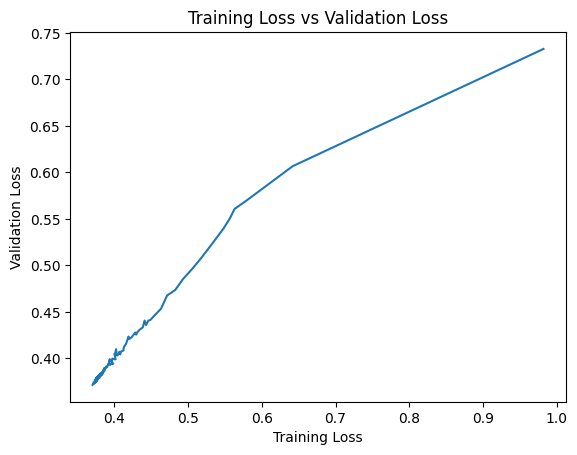

In [17]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x='Training Loss', y='Validation Loss', sort=False)
plt.title('Training Loss vs Validation Loss')
plt.show()

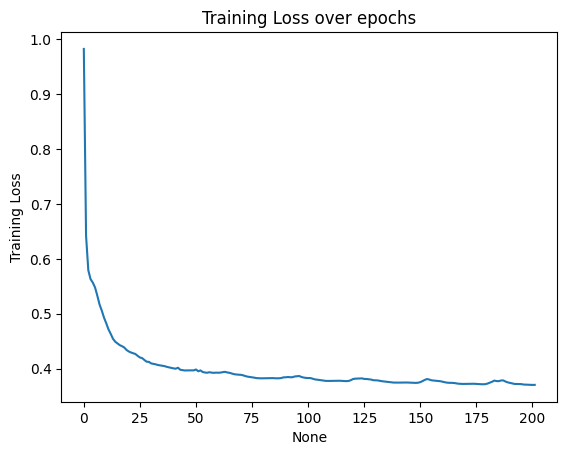

In [18]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Training Loss', sort=False)
plt.title('Training Loss over epochs')
plt.show()

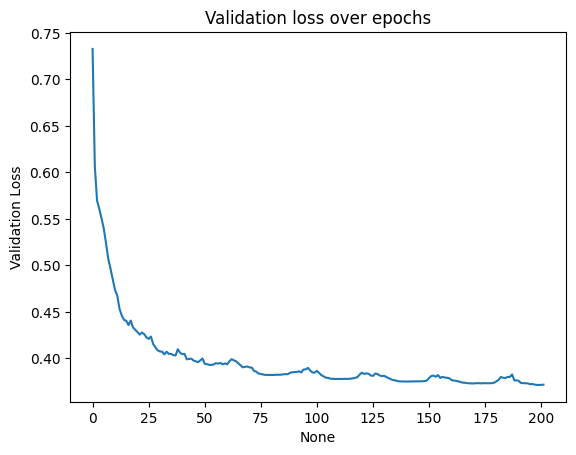

In [19]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Validation Loss', sort=False)
plt.title('Validation loss over epochs')
plt.show()

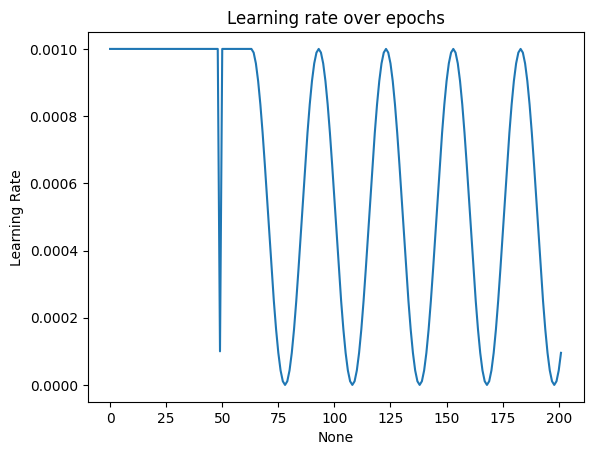

In [20]:
training_data = pd.read_csv(model_filepath+model_name+'.csv')
sns.lineplot(data=training_data, x=training_data.index, y='Learning Rate', sort=False)
plt.title('Learning rate over epochs')
plt.show()

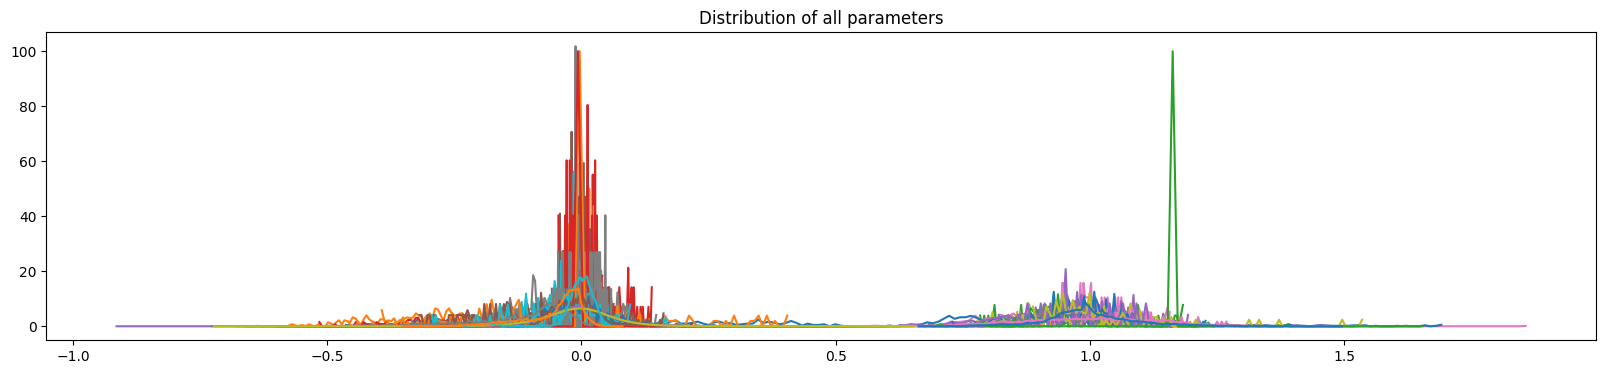

In [21]:
plt.figure(figsize=(20, 4)) # width and height of the plot

legends = []
for i, p in enumerate(conv_ae.parameters()):
    t = p.cpu()
    hy, hx = torch.histogram(t, density=True)
    plt.plot(hx[:-1].detach(), hy.detach())
plt.title('Distribution of all parameters');

name: encoders.0.1.weight Shape: torch.Size([64]) Mean: 0.9781014323234558, Std: 0.10790280997753143, saturated: 50.0
name: encoders.0.4.weight Shape: torch.Size([64]) Mean: 0.9971997737884521, Std: 0.0541766881942749, saturated: 68.75
name: encoders.1.1.weight Shape: torch.Size([128]) Mean: 0.9934070706367493, Std: 0.07297272980213165, saturated: 60.9375
name: encoders.1.4.weight Shape: torch.Size([128]) Mean: 0.9888308048248291, Std: 0.06526418775320053, saturated: 58.59375
name: encoders.2.1.weight Shape: torch.Size([256]) Mean: 0.9591447710990906, Std: 0.08788279443979263, saturated: 48.046875
name: encoders.2.4.weight Shape: torch.Size([256]) Mean: 0.9602075219154358, Std: 0.11138902604579926, saturated: 46.875
name: encoders.3.1.weight Shape: torch.Size([512]) Mean: 0.942874550819397, Std: 0.1756574809551239, saturated: 34.5703125
name: encoders.3.4.weight Shape: torch.Size([512]) Mean: 0.9173712134361267, Std: 0.21261057257652283, saturated: 27.1484375
name: decoders.0.1.weight 

C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\1795396973.py:5: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')


name: fc.1.weight Shape: torch.Size([8192]) Mean: 1.0044004917144775, Std: 0.09016864001750946, saturated: 67.05322265625


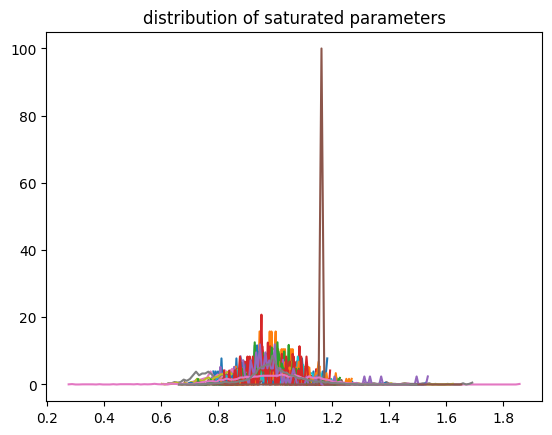

In [22]:
for name, param in conv_ae.named_parameters():
    t = param.cpu()
    saturated = (t.abs() > 0.97).float().mean()*100
    if saturated > 0.0:
        print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
plt.title('distribution of saturated parameters');


name: encoders.0.3.bias Shape: torch.Size([64]) Mean: -0.007649094797670841, Std: 0.03222028166055679, saturated: 0.0
name: encoders.1.0.bias Shape: torch.Size([128]) Mean: -0.004181188996881247, Std: 0.028927311301231384, saturated: 0.0
name: encoders.1.3.bias Shape: torch.Size([128]) Mean: -0.00226973881945014, Std: 0.021202336996793747, saturated: 0.0
name: encoders.2.0.bias Shape: torch.Size([256]) Mean: -0.0016211217734962702, Std: 0.021876174956560135, saturated: 0.0
name: encoders.2.3.bias Shape: torch.Size([256]) Mean: -0.0013051407877355814, Std: 0.01661158725619316, saturated: 0.0
name: encoders.3.0.bias Shape: torch.Size([512]) Mean: 0.00045792863238602877, Std: 0.01475407462567091, saturated: 0.0
name: encoders.3.3.bias Shape: torch.Size([512]) Mean: 0.0002818211796693504, Std: 0.011990330182015896, saturated: 0.0
name: decoders.0.0.bias Shape: torch.Size([512]) Mean: -2.3961212718859315e-05, Std: 0.012295850552618504, saturated: 0.0
name: decoders.0.3.bias Shape: torch.Siz

C:\Users\arthu\AppData\Local\Temp\ipykernel_21776\2010225207.py:4: UserWarning: std(): degrees of freedom is <= 0. Correction should be strictly less than the reduction factor (input numel divided by output numel). (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\ReduceOps.cpp:1823.)
  if t.std() < 0.05:


name: fc.0.bias Shape: torch.Size([8192]) Mean: -0.005736543331295252, Std: 0.04386531561613083, saturated: 0.0


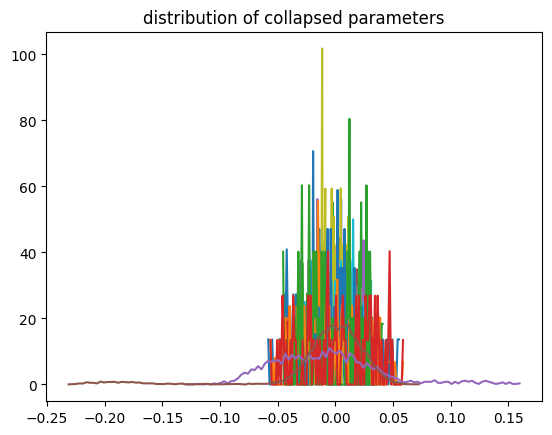

In [23]:
for name, param in conv_ae.named_parameters():
    t = param.cpu()
    saturated = (t.abs() > 0.97).float().mean()*100
    if t.std() < 0.05:
        print(f'name: {name} Shape: {t.shape} Mean: {t.mean()}, Std: {t.std()}, saturated: {saturated}')
        hy, hx = torch.histogram(t, density=True)
        plt.plot(hx[:-1].detach(), hy.detach())
plt.title('distribution of collapsed parameters');

In [ ]:
sample_input = frames_trainset.__getitem__(0)[0].unsqueeze(0).to(device)
sample_input.shape

torch.Size([1, 1, 129, 5])

In [16]:
# set log_stats flag to true to log activation statistics for each module
conv_ae.log_stats = True
with torch.no_grad():
    sample_output = conv_ae(sample_input)
conv_ae.log_stats = False
sample_output, sample_output.shape

(tensor([[[[0.0000e+00, 0.0000e+00, 0.0000e+00, 7.6900e-01, 1.1485e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.0288e-01, 1.0621e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3676e-01, 9.7572e-01],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.0540e-01, 9.6838e-01],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.7517e-01, 9.6362e-01],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.0246e-01, 1.0622e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 4.2686e-01, 1.1679e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 5.2307e-01, 1.2128e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 6.3736e-01, 1.2513e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 7.5634e-01, 1.2122e+00],
           [0.0000e+00, 0.0000e+00, 0.0000e+00, 8.7601e-01, 1.1617e+00],
           [0.0000e+00, 0.0000e+00, 4.2702e-02, 8.1093e-01, 1.1064e+00],
           [0.0000e+00, 0.0000e+00, 9.3462e-02, 7.1099e-01, 1.0501e+00],
           [0.0000e+00, 0.0000e+00, 3.4716e-01, 6.4

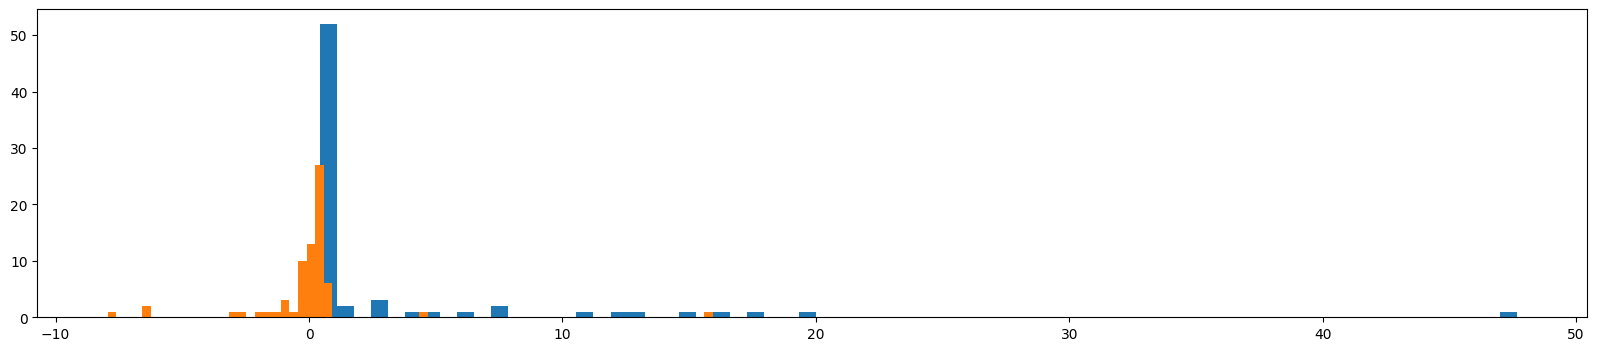

In [17]:
# accessing activation statistics saved to activation_stats by the forward hook
plt.figure(figsize=(20, 4))
s = []
m = []
for module, stats in activation_stats.items():
    s.append(stats['std'])
    m.append(stats['mean'])

plt.hist(s, len(s), label='Std of preactivations'); #  blue
plt.hist(m, len(m), label='Mean of preactivations'); # orange
